# Experiment with dataset 1_kaggle_jpaladin

Autistic and non-autistic children faces

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from os import path, listdir
import torch
import torchvision
from typing import Tuple, Dict

In [2]:
from torch import nn


def create_effnetb0_model(num_classes:int=7, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.
    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.
    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b0(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1280, out_features=num_classes),
    )
    
    return model, transforms

In [3]:
# Setup class names
class_names = ["Happy", "Disgusted", "Suprised","Angry","Neutral","Sad","Fearful"]

# Create EffNetB2 model
effnetb0, effnetb0_transforms = create_effnetb0_model(
    num_classes=7, # len(class_names) would also work
)

# Load saved weights


# Load saved weights
effnetb0.load_state_dict(
    torch.load(
        f="models/efficientnet_b0.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to C:\Users\foxel/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-3dd342df.pth
100.0%


<All keys matched successfully>

In [4]:
def predict(img) -> Dict:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    
    # Transform the target image and add a batch dimension
    img = effnetb0_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb0.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb0(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    
    return pred_labels_and_probs

In [42]:
datadir = r"D:\data\asd\1_kaggle_jpaladin\images"

image_list = ["autistic/" + example for example in listdir(path.join(datadir, "autistic"))]

In [15]:
from PIL import Image

In [27]:
def show_results(image, prob):
    argmax_key = max(prob, key=prob.get)
    argmax_val = '{0:.2f}'.format(prob[argmax_key] * 100)
    print(f'Prediction: {argmax_key} with probability { argmax_val }% ')
    display(image)

Prediction: Happy with probability 45.48% 


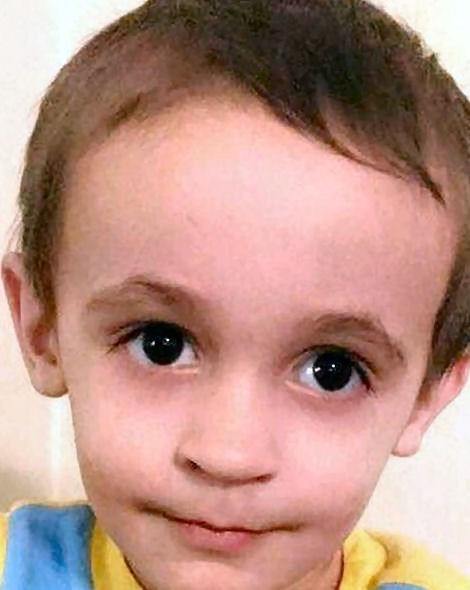

In [44]:
image = Image.open(path.join(datadir, image_list[0]))
probs = predict(image)
show_results(image, probs)

In [39]:
def assign_label(image, prob, counts, prob_level):
    argmax_key = max(prob, key=prob.get)
    argmax_val = prob[argmax_key] 
    counts[argmax_key] = counts[argmax_key] + 1
    prob_level[argmax_key] = prob_level[argmax_key] + argmax_val
    return counts, prob_level

In [45]:
counts = dict.fromkeys(class_names,0)
prob_level = dict.fromkeys(class_names,0)
for im in image_list:
    image = Image.open(path.join(datadir, im))
    probs = predict(image)
    counts, prob_level = assign_label(image, probs, counts, prob_level)
    
prob_level.update(zip(prob_level.keys(), [ y  / x  * 100 for (x,y) in zip(counts.values(), prob_level.values())]))

In [63]:
print(counts)

{'Happy': 827, 'Disgusted': 4, 'Suprised': 82, 'Angry': 71, 'Neutral': 434, 'Sad': 3, 'Fearful': 42}


In [64]:
print(prob_level)

{'Happy': 71.758455585828, 'Disgusted': 58.72436314821243, 'Suprised': 54.8237734633248, 'Angry': 52.15450789726955, 'Neutral': 60.6723445351772, 'Sad': 34.99150673548381, 'Fearful': 47.08987481537319}


## With YOLOv3 and VGG with darknet

In [66]:
from utils import *
from numpy import array
from darknet import Darknet
from torch.autograd import Variable
from torch.cuda import is_available as check_cuda
from PIL.ImageOps import grayscale
from fastai.vision.all import PILImage, load_learner

In [68]:
# For errors in Win 11
import pathlib 
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

In [72]:
# Emotion
learn_emotion = load_learner('models/emotions_vgg19.pkl')
learn_emotion_labels = learn_emotion.dls.vocab
print(learn_emotion_labels)

# Sentiment
learn_sentiment = load_learner('models/sentiment_vgg19.pkl')
learn_sentiment_labels = learn_sentiment.dls.vocab
print(learn_sentiment_labels)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['negative', 'neutral', 'positive']


In [73]:
################## DARKNET ##################
# Parameters
batch_size = 1
confidence = 0.25
nms_thresh = 0.30
run_cuda = False

# CFG Files
cfg     = 'cfg/yolov3-openimages.cfg'
clsnames= 'cfg/openimages.names'
weights = 'cfg/yolov3-openimages.weights'

# Load classes
classes = load_classes(clsnames)
num_classes = len(classes)

# Set up the neural network
print('Load Network')
model = Darknet(cfg)

print('Load Weights')
model.load_weights(weights)

print('Successfully loaded Network')

# Check CUDA
if run_cuda:
    CUDA = check_cuda()
else:
    CUDA = False

# Input dimension
inp_dim = int(model.net_info["height"])

# put the model on GPU
if CUDA:
    model.cuda()

# Set the model in evaluation mode
model.eval()

Load Network
Load Weights
Successfully loaded Network


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch

In [74]:

def get_detections(x):
    c1 = [int(y) for y in x[1:3]]
    c2 = [int(y) for y in x[3:5]]
    
    det_class = int(x[-1])
    label = "{0}".format(classes[det_class])
    
    return (label, tuple(c1 + c2))

# face detector
def detector(image):
    # Just lazy to update this
    imlist = [image]
    loaded_ims = [image]

    im_batches = list(map(prep_image, loaded_ims, [inp_dim for x in range(len(imlist))]))
    im_dim_list = [(x.shape[1], x.shape[0]) for x in loaded_ims]
    im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)

    leftover = 0
    if (len(im_dim_list) % batch_size):
        leftover = 1

    if batch_size != 1:
        num_batches = len(imlist) // batch_size + leftover            
        im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size,
                            len(im_batches))]))  for i in range(num_batches)]  

    write = 0
    if CUDA:
        im_dim_list = im_dim_list.cuda()
    
    for i, batch in enumerate(im_batches):
        # load the image 
        
        if CUDA:
            batch = batch.cuda()
        with torch.no_grad():
            prediction = model(Variable(batch), CUDA)

        prediction = write_results(prediction, confidence, num_classes, nms_conf = nms_thresh)

        if type(prediction) == int:

            for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
                im_id = i*batch_size + im_num
                
            continue

        prediction[:,0] += i*batch_size    # transform the atribute from index in batch to index in imlist 

        if not write: # If we have't initialised output
            output = prediction  
            write = 1
        else:
            output = torch.cat((output, prediction))

        for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
            im_id = i * batch_size + im_num
            objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]

        if CUDA:
            torch.cuda.synchronize()
       
    try:
        output
    except NameError:
        return loaded_ims[0], []

    im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())

    scaling_factor = torch.min(608/im_dim_list,1)[0].view(-1,1)

    output[:, [1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
    output[:, [2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2

    output[:, 1:5] /= scaling_factor

    for i in range(output.shape[0]):
        output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
        output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])
    
    detections = list(map(get_detections, output))

    if CUDA:
        torch.cuda.empty_cache()
    
    return loaded_ims[0], detections

In [106]:
def crop_images(img, bbox):
    "Here image should be an image object from PILImage.create"
    
    # Coordinates of face in cv2 format
    xmin, ymin, xmax, ymax = bbox[1]

    # resize and crop face
    return img.crop((xmin, ymin, xmax, ymax))


def detect_person_face(img, detections):
    '''This function is called from within detect face.
    If only a person is detected, then this will crop
    image and then try to detect face again.'''

    faces = []

    # Loop through people
    for detection in detections:
        
        # Get cropped image of person
        temp = crop_images(img, detection)

        # run detector again
        _, detect = detector(array(temp)[...,:3])
        
        # check for human faces
        human_face = [idx for idx, val in enumerate(detect) if val[0] == 'Human face']
        
        if len(human_face) == 0:
            continue
        # Force it to take only 1 face per person
        # crop face and append to list
        faces.append(crop_images(temp, detect[human_face[0]]))

    return faces


def detect_face(img):
    
    _, detections = detector(array(img)[...,:3])

    # check for human faces
    human_face = [idx for idx, val in enumerate(detections) if val[0] == 'Human face']

    if len(human_face) == 0:
        human_face = [idx for idx, val in enumerate(detections) if val[0] == 'Person']
    
        if len(human_face) == 0:
            return []
        else:
            # Only get human face detections
            faces = detect_person_face(img, [detections[idx] for idx in human_face])
    
    else:
        # Only get human face detections
        faces = []

        for idx in human_face:
            faces.append(crop_images(img, detections[idx]))
    
    return faces


# Predict
def predict(img):

    img = PILImage.create(img)

    # Detect faces
    faces = detect_face(img)

    output = []



    img = img.resize((48, 48))

    pred_emotion, pred_emotion_idx, probs_emotion = learn_emotion.predict(array(grayscale(img)))

    pred_sentiment, pred_sentiment_idx, probs_sentiment = learn_sentiment.predict(array(grayscale(img)))

    emotions = {learn_emotion_labels[i]: float(probs_emotion[i]) for i in range(len(learn_emotion_labels))}
    sentiments = {learn_sentiment_labels[i]: float(probs_sentiment[i]) for i in range(len(learn_sentiment_labels))}

    output = [img, emotions, sentiments]

    return output

Prediction: sad with probability 49.74% 


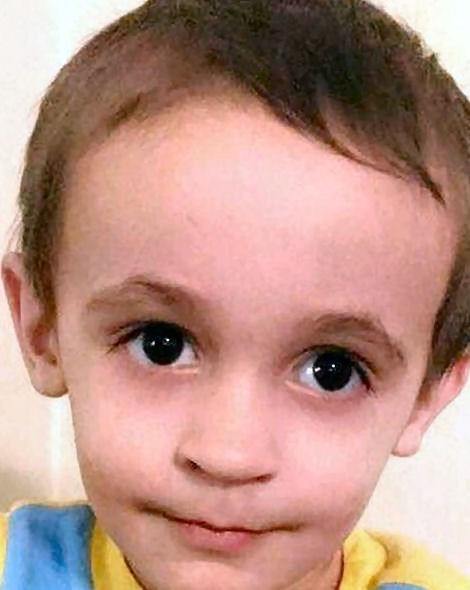

In [98]:
image_file = path.join(datadir, image_list[0])
probs = predict(image_file)
image = Image.open(image_file)
show_results(image, probs[1])

In [107]:
counts = dict.fromkeys(learn_emotion_labels,0)
prob_level = dict.fromkeys(learn_emotion_labels,0)
for im in image_list:
    
    image_file = path.join(datadir, im)
    probs = predict(image_file)
    image = Image.open(image_file)

    counts, prob_level = assign_label(image, probs[1], counts, prob_level)
    
prob_level.update(zip(prob_level.keys(), [ y  / x  * 100 for (x,y) in zip(counts.values(), prob_level.values())]))

In [113]:
print(f'{counts}')

{'angry': 121, 'disgust': 1, 'fear': 12, 'happy': 882, 'neutral': 304, 'sad': 131, 'surprise': 12}


In [114]:
print(f'{prob_level}')

{'angry': 68.13274471720389, 'disgust': 51.080673933029175, 'fear': 55.291188011566796, 'happy': 91.1547351586305, 'neutral': 77.7939995456683, 'sad': 62.11384459761263, 'surprise': 68.1723989546299}
